# Feature Engineering and Data Preparation

In [2]:
import pandas as pd 

deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

### 2. Data Cleaning

In [5]:
# Check for missing values
print(deliveries.isnull().sum())
print(matches.isnull().sum())

# Fill missing values for 'city' column
matches['city'] = matches['city'].fillna('Unknown')

# Convert date column to datetime format
matches['date'] = pd.to_datetime(matches['date'])


match_id                      0
season                        0
start_date                    0
venue                         0
innings                       0
ball                          0
batting_team                  0
bowling_team                  0
striker                       0
non_striker                   0
bowler                        0
runs_off_bat                  0
extras                        0
wides                     17237
noballs                   17763
byes                      17818
legbyes                   17616
penalty                   17863
wicket_type               16947
player_dismissed          16947
other_wicket_type         17863
other_player_dismissed    17863
dtype: int64
season              0
team1               0
team2               0
date                0
match_number        0
venue               0
city                0
toss_winner         0
toss_decision       0
player_of_match     1
umpire1             0
umpire2             0
reserve_umpire     

### 3. Feature Engineering

#### Match Outcome

In [9]:
print(matches.columns)

Index(['season', 'team1', 'team2', 'date', 'match_number', 'venue', 'city',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'reserve_umpire', 'match_referee', 'winner', 'winner_runs',
       'winner_wickets', 'match_type'],
      dtype='object')


In [11]:
# Create a result feature based on whether the match was won by runs or wickets
matches['result'] = matches.apply(
    lambda row: 1 if row['winner_runs'] > 0 else (0 if row['winner_wickets'] > 0 else None), axis=1
)

#### Toss Impact

In [14]:
# Create a feature to check the impact of winning the toss
matches['toss_impact'] = matches.apply(lambda row: 1 if row['toss_winner'] == row['winner'] else 0, axis=1)

#### Run Rate Calculation

In [17]:
print(deliveries.columns)

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')


In [19]:
# Create the 'over' column based on the 'ball' column
deliveries['over'] = deliveries['ball'].apply(lambda x: (x - 1) // 6 + 1)

# Calculate the cumulative runs to calculate run rate
deliveries['total_runs'] = deliveries['runs_off_bat'] + deliveries['extras']

# Calculate the run rate for each over
deliveries['run_rate'] = deliveries.groupby(['match_id', 'innings'])['total_runs'].cumsum() / deliveries['over']

# View the updated DataFrame
print(deliveries.head())


   match_id  season  start_date                             venue  innings  \
0   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  byes  legbyes  penalty  wicket_type  player_dismissed  other_wicke

#### Cumulative Runs and Wickets

In [22]:
# Create the 'total_runs' column
deliveries['total_runs'] = deliveries['runs_off_bat'] + deliveries['extras']

# Create the 'is_wicket' column (1 if there's a wicket, 0 otherwise)
deliveries['is_wicket'] = deliveries['wicket_type'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Calculate cumulative runs and wickets for each inning
deliveries['cumulative_runs'] = deliveries.groupby(['match_id', 'innings'])['total_runs'].cumsum()
deliveries['cumulative_wickets'] = deliveries.groupby(['match_id', 'innings'])['is_wicket'].cumsum()

# View the updated DataFrame
print(deliveries.head())

   match_id  season  start_date                             venue  innings  \
0   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  wicket_type  player_dismissed  other_wicket_type  other_player_dis

#### Bowling Economy

In [25]:
# Ensure correct calculation of bowler runs (excluding byes and legbyes)
deliveries['bowler_runs'] = deliveries['runs_off_bat'] + deliveries['extras'] - (deliveries['byes'] + deliveries['legbyes'])

# Group by match and bowler to aggregate runs conceded and balls bowled
bowler_data = deliveries.groupby(['match_id', 'bowler']).agg(
    runs_conceded=('bowler_runs', 'sum'),
    balls_bowled=('ball', 'count')
).reset_index()

# Calculate economy rate (runs per over)
bowler_data['economy_rate'] = bowler_data['runs_conceded'] / (bowler_data['balls_bowled'] / 6)

# View the bowler data with economy rate
print(bowler_data.head())

   match_id      bowler  runs_conceded  balls_bowled  economy_rate
0   1359475   AS Joseph            0.0            24           0.0
1   1359475   DL Chahar            0.0            24           0.0
2   1359475   HH Pandya            0.0            18           0.0
3   1359475    J Little            0.0            24           0.0
4   1359475  MJ Santner            0.0            24           0.0


#### Partnerships

In [28]:
# Ensure the 'total_runs' column is created
deliveries['total_runs'] = deliveries['runs_off_bat'] + deliveries['extras']

# Create a unique partnership identifier for each pair of batsmen
deliveries['partnership_id'] = deliveries.apply(
    lambda row: tuple(sorted([row['striker'], row['non_striker']])), axis=1
)

# Calculate cumulative runs for each partnership
deliveries['cumulative_partnership_runs'] = deliveries.groupby(
    ['match_id', 'innings', 'partnership_id']
)['total_runs'].cumsum()

# View the updated DataFrame
print(deliveries[['match_id', 'innings', 'striker', 'non_striker', 'partnership_id', 'cumulative_partnership_runs']].head())


   match_id  innings     striker non_striker           partnership_id  \
0   1359475        1   DP Conway  RD Gaikwad  (DP Conway, RD Gaikwad)   
1   1359475        1   DP Conway  RD Gaikwad  (DP Conway, RD Gaikwad)   
2   1359475        1  RD Gaikwad   DP Conway  (DP Conway, RD Gaikwad)   
3   1359475        1  RD Gaikwad   DP Conway  (DP Conway, RD Gaikwad)   
4   1359475        1   DP Conway  RD Gaikwad  (DP Conway, RD Gaikwad)   

   cumulative_partnership_runs  
0                            0  
1                            1  
2                            1  
3                            2  
4                            2  


### 4. Data Merging

In [31]:
# Rename column in matches DataFrame to match 'match_id'
matches.rename(columns={'match_number': 'match_id'}, inplace=True)

# Now perform the merge
merged_df = deliveries.merge(matches, on='match_id', how='left')

# View the merged DataFrame
print(merged_df.head())

   match_id  season_x  start_date                           venue_x  innings  \
0   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  umpire1  umpire2  reserve_umpire  match_referee  winne

In [33]:
print(merged_df.head())
print(merged_df.columns)

   match_id  season_x  start_date                           venue_x  innings  \
0   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475      2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  umpire1  umpire2  reserve_umpire  match_referee  winne

### 5. Feature Transformation

#### Normalization/Standardization

In [37]:
print(merged_df.columns)

Index(['match_id', 'season_x', 'start_date', 'venue_x', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'over', 'total_runs', 'run_rate', 'is_wicket',
       'cumulative_runs', 'cumulative_wickets', 'bowler_runs',
       'partnership_id', 'cumulative_partnership_runs', 'season_y', 'team1',
       'team2', 'date', 'venue_y', 'city', 'toss_winner', 'toss_decision',
       'player_of_match', 'umpire1', 'umpire2', 'reserve_umpire',
       'match_referee', 'winner', 'winner_runs', 'winner_wickets',
       'match_type', 'result', 'toss_impact'],
      dtype='object')


In [39]:
# Calculate total_runs for each over
deliveries['total_runs'] = deliveries[['runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty']].sum(axis=1)

# Convert 'over' to float to avoid division issues
deliveries['over'] = deliveries['over'].astype(float)

# Calculate cumulative runs and run rate for each inning
deliveries['cumulative_runs'] = deliveries.groupby(['match_id', 'innings'])['total_runs'].cumsum()
deliveries['run_rate'] = deliveries['cumulative_runs'] / (deliveries['over'])


#### Categorical Encoding

In [42]:
# One-Hot Encoding for teams and cities
encoded_df = pd.get_dummies(merged_df, columns=['batting_team', 'bowling_team', 'city'])

### 6. Derived Features

#### Momentum and Pressure Situations

In [46]:
print(deliveries.columns)

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'over', 'total_runs', 'run_rate', 'is_wicket',
       'cumulative_runs', 'cumulative_wickets', 'bowler_runs',
       'partnership_id', 'cumulative_partnership_runs'],
      dtype='object')


In [48]:
# Ensure numeric columns
deliveries['total_runs'] = pd.to_numeric(deliveries['total_runs'], errors='coerce')
deliveries['innings'] = pd.to_numeric(deliveries['innings'], errors='coerce')

# Compute rolling sum
rolling_sum = (
    deliveries
    .groupby(['match_id', 'innings'])['total_runs']
    .rolling(window=30, min_periods=1)
    .sum()
)

# Reset index to align with the original DataFrame
rolling_sum = rolling_sum.reset_index(level=[0, 1], drop=True)

# Assign to DataFrame
deliveries['last_5_overs_runs'] = rolling_sum


In [50]:
import pandas as pd

# Example DataFrame (assuming 'deliveries' is already loaded)
# deliveries = pd.read_csv('your_deliveries_data.csv')

# Ensure numeric columns are properly formatted
deliveries['total_runs'] = pd.to_numeric(deliveries['total_runs'], errors='coerce')
deliveries['innings'] = pd.to_numeric(deliveries['innings'], errors='coerce')

# Compute rolling sum of runs in the last 5 overs (30 balls)
# The rolling window is set to 30 balls (5 overs), with min_periods=1 to handle less than 5 overs
rolling_sum = (
    deliveries
    .groupby(['match_id', 'innings'])['total_runs']
    .rolling(window=30, min_periods=1)
    .sum()
)

# Reset index to align the rolling sum with the original DataFrame
rolling_sum = rolling_sum.reset_index(level=[0, 1], drop=True)

# Assign the rolling sum to a new column in the DataFrame
deliveries['last_5_overs_runs'] = rolling_sum

# Display the DataFrame to verify the new feature
print(deliveries.head())


   match_id  season  start_date                             venue  innings  \
0   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  over  total_runs  run_rate  is_wicket  cumulative_runs  cumulative

### 7. Data Aggregation

#### Match-level Aggregation

In [54]:
print("Columns in matches DataFrame:")
print(matches.columns)

Columns in matches DataFrame:
Index(['season', 'team1', 'team2', 'date', 'match_id', 'venue', 'city',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'reserve_umpire', 'match_referee', 'winner', 'winner_runs',
       'winner_wickets', 'match_type', 'result', 'toss_impact'],
      dtype='object')


In [56]:
print("Sample data from deliveries DataFrame:")
print(deliveries.head())

print("Sample data from matches DataFrame:")
print(matches.head())


Sample data from deliveries DataFrame:
   match_id  season  start_date                             venue  innings  \
0   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
1   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
2   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
3   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   
4   1359475    2023  2023-03-31  Narendra Modi Stadium, Ahmedabad        1   

   ball         batting_team    bowling_team     striker non_striker  ...  \
0   0.1  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
1   0.2  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   
2   0.3  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
3   0.4  Chennai Super Kings  Gujarat Titans  RD Gaikwad   DP Conway  ...   
4   0.5  Chennai Super Kings  Gujarat Titans   DP Conway  RD Gaikwad  ...   

  over  total_runs  run_rate 

## 8. Visualization

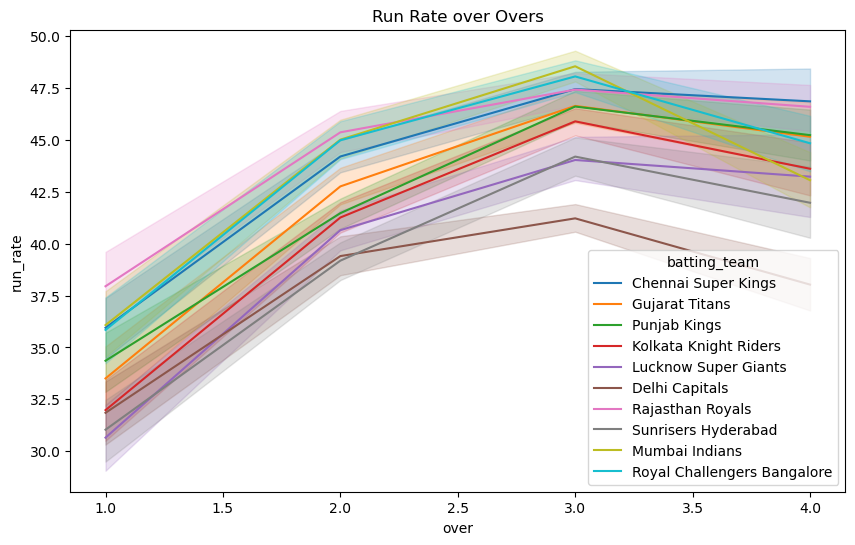

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualize run rates over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='over', y='run_rate', hue='batting_team')
plt.title('Run Rate over Overs')
plt.show()
